<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогнозирование заказов такси</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
    
__Постановка задачи:__ предсказать количество заказов на следующий час в каждом округе Чикаго
    
__Оценка результата:__ Сравнение качества работы моделей. Значение метрики 
    
__Описание данных:__ Исторические данные о поездках такси в Чикаго
    
- Trip ID: Уникальный идентификатор поездки.
- Taxi ID: Уникальный идентификатор такси.
- Trip Start Timestamp: Время начала поездки, округленное до ближайших 15 минут.
- Trip End Timestamp: Время окончания поездки, округленное до ближайших 15 минут.
- Trip Seconds: Продолжительность поездки в секундах.
- Trip Miles: Расстояние поездки в милях.
- Pickup Census Tract: Территория переписи, с которой началась поездка. Для защиты конфиденциальности для некоторых поездок данная - информация не отображается. Для мест за пределами Чикаго эта колонка часто будет пустой.
- Dropoff Census Tract: Территория переписи, на которой завершилась поездка. Для защиты конфиденциальности для некоторых поездок данная информация не отображается. Для мест за пределами Чикаго эта колонка часто будет пустой.
- Pickup Community Area: Общественная территория, с которой началась поездка. Для мест за пределами Чикаго эта колонка будет пустой.
- Dropoff Community Area: Общественная территория, на которой завершилась поездка. Для мест за пределами Чикаго эта колонка будет пустой.
- Fare: Стоимость поездки.
- Tips: Чаевые за поездку. Обычно наличные чаевые не записываются.
- Tolls: Плата за дорожные сборы (платные дороги) во время поездки.
- Extras: Дополнительные затраты на поездку.
- Trip Total: Общая стоимость поездки, сумма предыдущих столбцов.
- Payment Type: Тип оплаты за поездку.
- Company: Компания-владелец такси.
- Pickup Centroid Latitude: Широта центральной точки территории переписи или общественной территории, с которой началась поездка.
- Pickup Centroid Longitude: Долгота центральной точки территории переписи или общественной территории, с которой началась поездка.
- Pickup Centroid Location: Местоположение центральной точки территории переписи или общественной территории, с которой началась поездка.
- Dropoff Centroid Latitude: Широта центральной точки территории переписи или общественной территории, на которой завершилась поездка.
- Dropoff Centroid Longitude: Долгота центральной точки территории переписи или общественной территории, на которой завершилась поездка.
- Dropoff Centroid Location: Местоположение центральной точки территории переписи или общественной территории, на которой завершилась поездка.






    
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [83]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from datetime import timedelta, datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# константы
RANDOM_SEED = 42

In [2]:
# запуск spark-сессии
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting")\
.master(f"spark://{SPARK_MASTER_IP}:7077")\
.config("spark.executor.cores", 1)\
.config("spark.task.cpus", 1)\
.getOrCreate()

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [66]:
# загрузка данных
try:
    df_22 = spark.read.csv('data/Taxi_Trips_-_2022.csv', header=True, inferSchema=True)
    df_23 = spark.read.csv('data/Taxi_Trips_-_2023.csv', header=True, inferSchema=True)
    display('Данные загружены корректно')
except:
    display('Данные не доступны')
    raise SystemExit(0)

'Данные загружены корректно'

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка данных

</div>

__Сравнение признаков:__

In [4]:
# получение признаков из df_22 и df_23
columns_df_22 = df_22.columns
columns_df_23 = df_23.columns

# сравнение признаков
common_columns = set(columns_df_22) & set(columns_df_23)
unique_columns_df_22 = set(columns_df_22) - common_columns
unique_columns_df_23 = set(columns_df_23) - common_columns

# вывод результатов
print("Общие признаки:", common_columns)
print("Признаки уникальные для df_22:", unique_columns_df_22)
print("Признаки уникальные для df_23:", unique_columns_df_23)

Общие признаки: {'Extras', 'Trip Miles', 'Payment Type', 'Dropoff Census Tract', 'Dropoff Centroid Latitude', 'Dropoff Community Area', 'Company', 'Trip Seconds', 'Pickup Centroid Location', 'Pickup Census Tract', 'Fare', 'Trip Start Timestamp', 'Pickup Centroid Latitude', 'Tips', 'Tolls', 'Pickup Community Area', 'Trip Total', 'Trip End Timestamp', 'Dropoff Centroid  Location', 'Dropoff Centroid Longitude', 'Taxi ID', 'Pickup Centroid Longitude', 'Trip ID'}
Признаки уникальные для df_22: set()
Признаки уникальные для df_23: set()


- Результаты сравнения признаков говорят о том, что оба датафрейма (df_22 и df_23) имеют одинаковый набор признаков, и в них нет уникальных признаков для каждого года. Это  облегчает задачу объединения данных и анализа в рамках проекта.

Из всех признаков нам необходимы:
- Trip Start Timestamp: Время начала поездки, округленное до ближайших 15 минут.
- Pickup Community Area: Общественная территория, с которой началась поездка. Этот признак указывает на округ (community area), в котором началась поездка.(пропуски обозначаюз поездки за пределами города)

__Проверка данных на наличие дубликатов__

In [5]:
def duplicates(df):
    duplicates = df.groupBy(df.columns).count().filter(F.col('count') > 1)
    if duplicates.count() > 0:
        print('Обнаружены дубликаты:')
        duplicates.show()
    else: print('Дубликаты отсутствуют')

In [6]:
# проверка данных за 2022г.
duplicates(df_22)

Дубликаты отсутствуют


In [7]:
# проверка данных за 2023г.
duplicates(df_23)

Дубликаты отсутствуют


__Объединение датасетов__

In [8]:
# исходный размер датасетов
print(f'Количество строк в df_22: {df_22.count()}')
print(f'Количество строк в df_23: {df_23.count()}')

Количество строк в df_22: 6382425
Количество строк в df_23: 3783730


In [11]:
# выбор столбцов `Trip Start Timestamp` и `Pickup Community Area` из df_22
df_22_selected = df_22.select('Trip Start Timestamp', 'Pickup Community Area')

# выбор столбцов `Trip Start Timestamp` и `Pickup Community Area` из df_23
df_23_selected = df_23.select('Trip Start Timestamp', 'Pickup Community Area')

# объединение данных из df_22 и df_23
df = df_22_selected.union(df_23_selected)

In [12]:
# проверка корректности объединения
if df.count() == df_22.count() + df_23.count():
    print("Данные объеденены корректно")
else: print("Данные объеденены некорректно")

Данные объеденены корректно


__Обработка пропусков__

Пропуски в текущих данных означают поездки за городом

In [13]:
# удаление записей с пропусками из датафрейма
df_cleaned = df.na.drop(how='any')

# количество строк до и после удаления пропусков
print(f'Количество строк до удаления пропусков: {df.count()}')
print(f'Количество строк после удаления пропусков: {df_cleaned.count()}')

Количество строк до удаления пропусков: 10166155
Количество строк после удаления пропусков: 9484535


__Типы данных__

In [14]:
# схема данных для датафрейма df_cleaned
df_cleaned.printSchema()

root
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)



In [15]:
# преобразование столбца `Trip Start Timestamp` в тип данных timestamp
df = df_cleaned.withColumn('Trip Start Timestamp', F.to_timestamp(F.col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))

In [16]:
# округление времени до ближайшего часа
df = df.withColumn('Trip Start Timestamp', F.date_trunc('hour', 'Trip Start Timestamp'))

In [17]:
# агрегация данных и подсчет количества одинаковых строк
agg_df = df.groupBy('Trip Start Timestamp', 'Pickup Community Area') \
           .agg(F.count('*').alias('count'))

# переименование столбцов
agg_df = agg_df.withColumnRenamed('Trip Start Timestamp', 'time') \
               .withColumnRenamed('Pickup Community Area', 'area')

# просмотр первых 5-ти записей в агрегированном датафрейме
agg_df.show(5)

+-------------------+----+-----+
|               time|area|count|
+-------------------+----+-----+
|2022-01-01 02:00:00|  22|   13|
|2022-01-01 05:00:00|  28|    3|
|2022-01-01 13:00:00|  44|    2|
|2022-01-01 14:00:00|  36|    2|
|2022-01-01 15:00:00|  13|    1|
+-------------------+----+-----+
only showing top 5 rows



In [18]:
# подсчет количества уникальных значений в столбце `area`
unique_areas_count = agg_df.select('area').distinct().count()
print(f'Количество уникальных значений в столбце `area`: {unique_areas_count}')

Количество уникальных значений в столбце `area`: 77


- У нас представленны данные по 77 [округам](https://en.wikipedia.org/wiki/Community_areas_in_Chicago), что соответствует дейцствительности.

__Проверим хронологический порядок данных:__

In [19]:
def num_out_of_order_areas(df):
    # оконная функция для сортировки данных по времени внутри каждого округа
    window_spec = Window.partitionBy('area').orderBy('time')
    # сортировка данных
    sorted_df = agg_df.withColumn('sorted', F.row_number().over(window_spec))
    # проверка хронологии данных для каждого округа
    sorted_df = sorted_df.filter(F.col('sorted') > 1)
    # подсчет количества округов, где хронология нарушена
    sorted_df = sorted_df.select('area').distinct()
    count = sorted_df.count()
    sorted_df = None
    return count

In [20]:
print(f'Количество округов, где хронология нарушена: {num_out_of_order_areas(agg_df)}')

Количество округов, где хронология нарушена: 77


- В каждом округе, за время наблюдения, случалиси часы в которые небыло заказов такси, необходимо восстановить эти данные. отобразив нулевое количество заказов

In [25]:
# поиск минимального и максимального значения времени в agg_df
min_time = agg_df.select(F.min('time')).first()[0]
max_time = agg_df.select(F.max('time')).first()[0]

# создание временного ряда
time_range = [(min_time + timedelta(hours=i)) for i in range(int((max_time - min_time).total_seconds() / 3600) + 1)]
# создание DataFrame с временным рядом
time_series_df = spark.createDataFrame([(t,) for t in time_range], ['time'])

# создание DataFrame с уникальными округами
unique_areas_df = agg_df.select('area').distinct()

# добавление столбца time к каждому округу
full_data = unique_areas_df.crossJoin(time_series_df)

# присоединение агрегированных данных к полному временному ряду
result_df = full_data.join(agg_df, ['time', 'area'], 'left').fillna(0, subset=['count'])

# вывод результат
result_df.show(5)

+-------------------+----+-----+
|               time|area|count|
+-------------------+----+-----+
|2022-01-01 00:00:00|  65|    0|
|2022-01-01 00:00:00|  76|   24|
|2022-05-09 00:00:00|  31|    0|
|2022-05-09 00:00:00|  34|    2|
|2022-05-09 00:00:00|  65|    0|
+-------------------+----+-----+
only showing top 5 rows



Проверим корректность восстановления хронологических данных:
  - Сумма заказов исходных данных должна совпадать с суммой заказов в данных с восстановленным хронологическим порядком.

In [26]:
if result_df.agg(F.sum('count')).collect()[0][0] == agg_df.agg(F.sum('count')).collect()[0][0]:
    print('Хронологический порядок данных востановлен корректно')
else: print('Данные искаженны')

Хронологический порядок данных востановлен корректно


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Анализ данных

</div>

__Общая информация__

In [27]:
result_df.describe('count').show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|          1066373|
|   mean|8.894200247005504|
| stddev|35.12365798973102|
|    min|                0|
|    max|              591|
+-------+-----------------+



- Общий анализ сводки говорит о том, что есть значительная изменчивость количества заказов такси по часам и округам в Чикаго, а также некоторые пики активности, которые могут быть связаны с определенными событиями или периодами.

__Зависимость среднего количества заказов в час от округа__

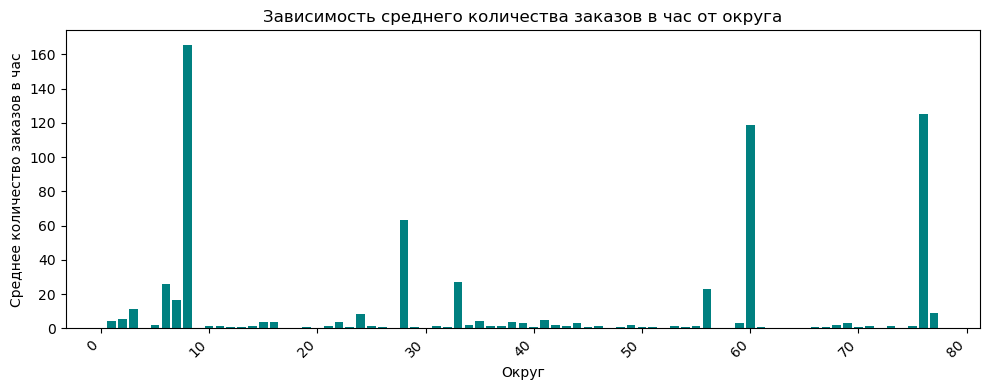

In [28]:
# группировка данных по округам и рассчет среднее количество заказов
avg_orders_by_area = result_df.groupBy('area').agg(F.mean('count').alias('avg_count'))

# получение данных для построения графика
areas = avg_orders_by_area.select('area').rdd.flatMap(lambda x: x).collect()
avg_counts = avg_orders_by_area.select('avg_count').rdd.flatMap(lambda x: x).collect()

# построение графика
plt.figure(figsize=(10, 4))
plt.bar(areas, avg_counts, color='teal')
plt.xlabel('Округ')
plt.ylabel('Среднее количество заказов в час')
plt.title('Зависимость среднего количества заказов в час от округа')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Наблюдается большой разброс среднего количества заказов в час между округами, что может указывать на неравномерное использование такси в разных часах и в разных частях города.
- График позволяет выделить округа с высокой и низкой активностью заказов, что может быть полезной информацией для планирования ресурсов и управления такси в разных частях города.

__Зависимость среднего количества заказов такси от часа__

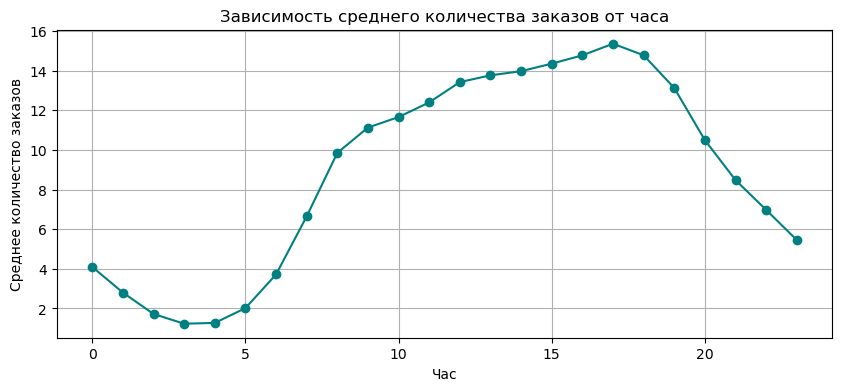

In [29]:
# рассчет признака с часом
result_df_with_hour = result_df.withColumn('hour', F.hour('time'))

# рассчет среднего количество заказов по часам
avg_counts_by_hour = result_df_with_hour.groupBy('hour').agg(F.avg('count').alias('avg_count')).orderBy('hour')
avg_counts_by_hour_pd = avg_counts_by_hour.toPandas()

# построение графика
plt.figure(figsize=(10, 4))
plt.plot(avg_counts_by_hour_pd['hour'], avg_counts_by_hour_pd['avg_count'], marker='o', color='teal')
plt.title('Зависимость среднего количества заказов от часа')
plt.xlabel('Час')
plt.ylabel('Среднее количество заказов')
plt.grid(True)
plt.show()

- Из графика и данных видно, что среднее количество заказов такси в Чикаго имеет характерный пик в период с 16 до 18 часов, что, вероятно, связано с концом рабочего дня и повышенным спросом на транспорт. Также интересно, что в период ночных часов (с 0 до 5 часов) количество заказов снижается, что может быть обусловлено менее активной деятельностью и пониженным спросом на такси в эти часы.

__Зависимость среднего количества заказов такси от дня недели__

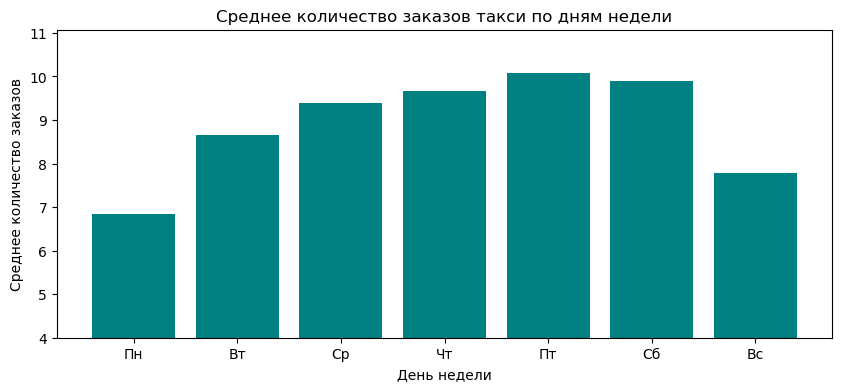

In [30]:
# рассчет среднего количества заказов такси по дням недели
avg_counts_by_weekday = result_df.groupBy(F.dayofweek('time').alias('weekday')).avg('count').orderBy('weekday')

# подготовка данных
weekdays = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
avg_counts = avg_counts_by_weekday.select('avg(count)').rdd.flatMap(lambda x: x).collect()

# построение графика
plt.figure(figsize=(10, 4))
plt.bar(weekdays, avg_counts, color='teal')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.title('Среднее количество заказов такси по дням недели')
plt.xticks(rotation=0)
plt.ylim(4, max(avg_counts) + 1)  # установка начального значения оси Y на 4
plt.show()

- График отражает зависимость среднего количества заказов такси от дня недели в городе Чикаго. Из него видно, что наибольшее среднее количество заказов приходится на четверг, пятницу и субботу. Это может быть связано с активностью вечерних и ночных мероприятий, а также с возможностью отдохнуть от работы в конце недели. 

__Зависимость среднего количества заказов такси от месяца года__

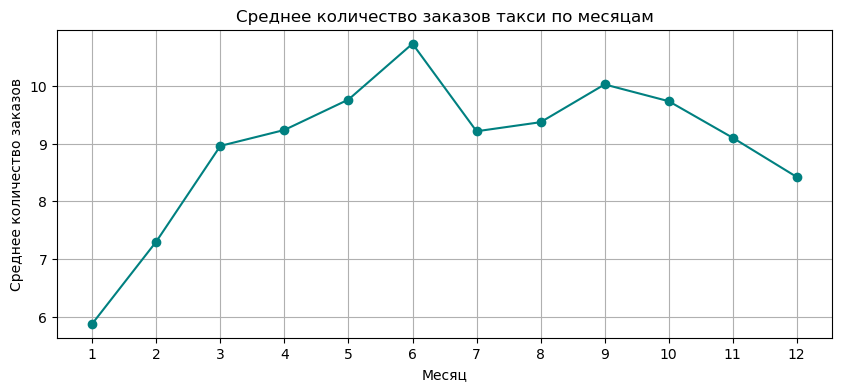

In [31]:
# рассчет среднего количества заказов по месяцам
avg_counts_by_month = result_df.groupBy(F.month('time').alias('month')).agg(F.avg('count').alias('avg_count')).orderBy('month')

months = [row.month for row in avg_counts_by_month.select('month').collect()]
avg_counts = [row.avg_count for row in avg_counts_by_month.select('avg_count').collect()]

# построение графика
plt.figure(figsize=(10, 4))
plt.plot(months, avg_counts, marker='o', color='teal')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.title('Среднее количество заказов такси по месяцам')
plt.xticks(months)
plt.grid(True)
plt.show()

- Из графика зависимости среднего количества заказов такси от месяца видно, что наибольшее среднее количество заказов приходится на месяцы: июнь и сентябрь. Это может быть связано с тем, что летом и в начале осени люди чаще путешествуют, проводят время на отдыхе и посещают различные мероприятия, что ведет к увеличению спроса на такси. Наименьшее среднее количество заказов наблюдается в декабре, возможно, из-за того, что это время года связано с праздниками и отпусками, когда многие люди остаются дома или уезжают из города.

## Визуализация трендов и сезонности временного ряда
- Посмотрим на тренд и сезонность всего временного ряда
- Визуализируем данные за последний месяц

In [33]:
# агрегация данных по дате
agg_result = result_df.groupBy('time').agg(F.avg('count').alias('avg_count'))
# преобразование Pandas DataFrame для декомпозиции
agg_result = agg_result.select("time", "avg_count").toPandas()
# установка столбеца `time` как индекс
agg_result.set_index('time', inplace=True)
# сортировка данных
agg_result = agg_result.sort_index(ascending=True)
# вывод данных
display(agg_result.head(2))

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,avg_count
time,
2022-01-01 00:00:00,5.727273
2022-01-01 01:00:00,7.402597


In [34]:
# проверка хронологии данных
if agg_result.index.is_monotonic_increasing:
    print('Данные представлены в хронологическом порядке')
else: print('Хронологический порядок в данных нарушен')

Данные представлены в хронологическом порядке


In [35]:
# декомпозиция
decomposition = seasonal_decompose(agg_result)

__Тренд всего временного ряда__

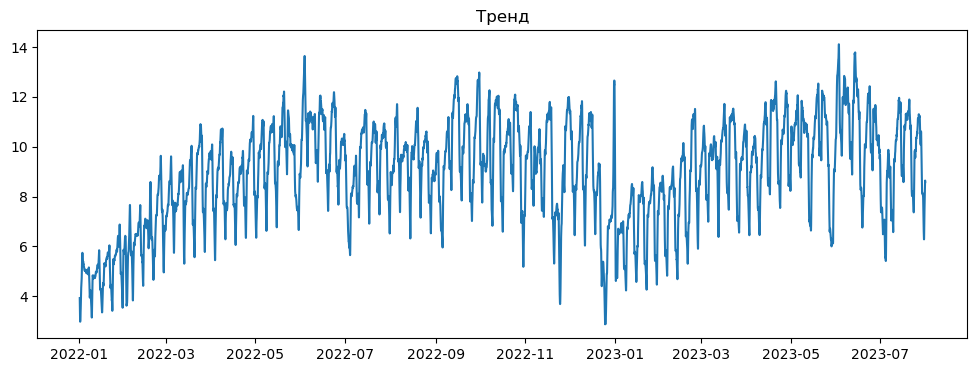

In [36]:
# визуализизвция тренда всего временного ряда
plt.figure(figsize=(12, 4))
plt.plot(decomposition.trend)
plt.title('Тренд')
plt.show()

__Тренд, сезонность, остатки временного ряда за последний месяц__

In [37]:
print(f'Данные представленны в промежутке от {agg_result.index.min()} до {agg_result.index.max()}')

Данные представленны в промежутке от 2022-01-01 00:00:00 до 2023-08-01 00:00:00


<function matplotlib.pyplot.show(close=None, block=None)>

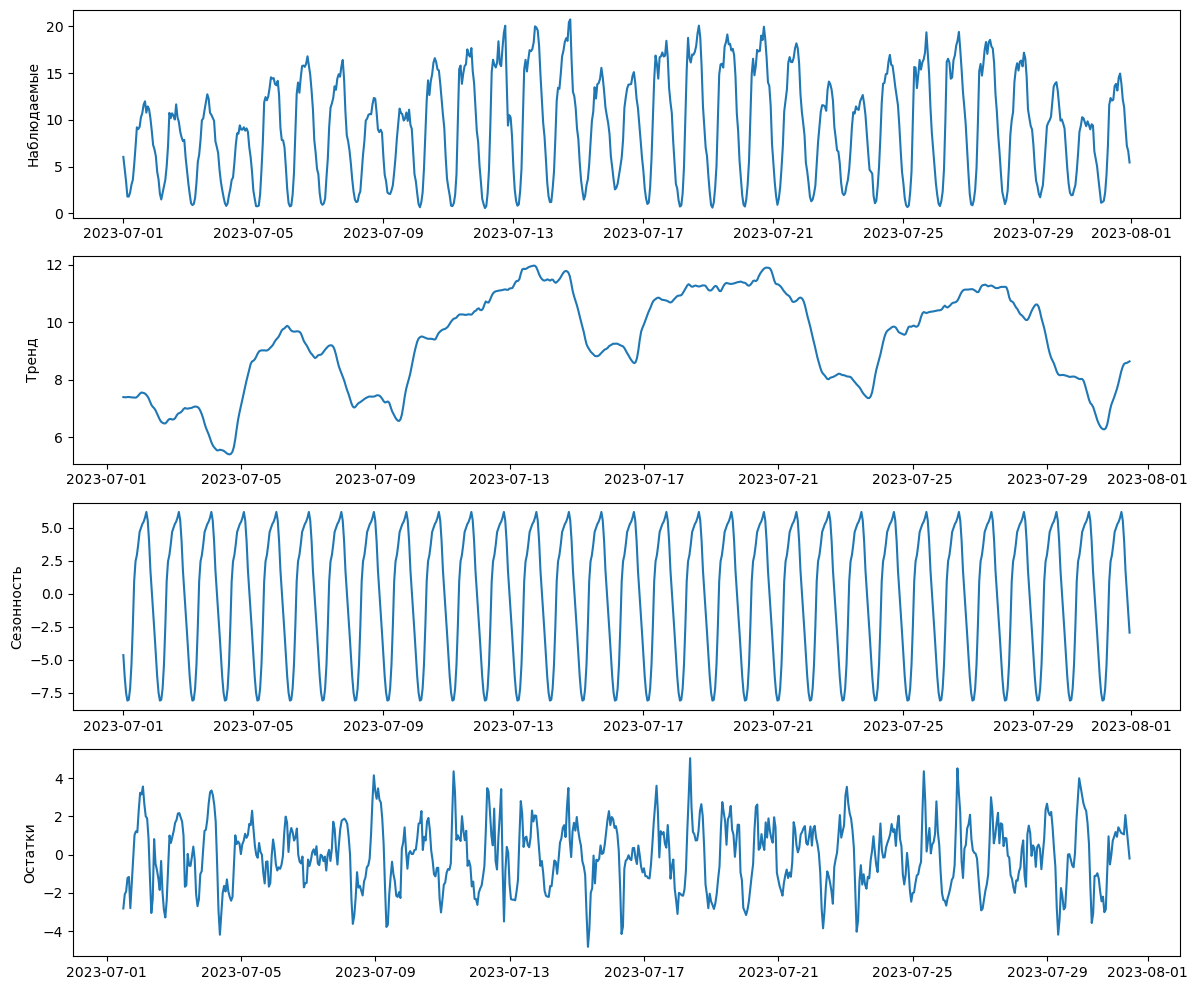

In [38]:
decomposition = seasonal_decompose(agg_result['2023-07':'2023-07'])

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.observed)
plt.ylabel('Наблюдаемые')

plt.subplot(4, 1, 2)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.trend)
plt.ylabel('Тренд')

plt.subplot(4, 1, 3)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.seasonal)
plt.ylabel('Сезонность')

plt.subplot(4, 1, 4)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.resid)
plt.ylabel('Остатки')

plt.tight_layout()
plt.show

- На общем тренде можно наблюдать сезонность заказов такси.
- Присутствует недельная сезонность.
- Так же следует отметить суточную сезонность, на дневные часы приходся пиковое значение заказов.

__Проверка приводимости временного ряда к стационарному__

In [39]:
ts = agg_result['avg_count']
st_test = adfuller(ts, regression='ctt')
# если значение с индексом 1 меньше P-Value (0.05), то ряд приводим к стационарному
if st_test[1] < 0.05: print('Временной ряд приводим к стационарному')
else: print('Временной ряд не может быть приведен к стационарному')

Временной ряд приводим к стационарному


- Временной ряд приводим к стационарному, как следствие, данные подлежат прогнозированю.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению модели
    
</div>

- Так как присутствует суточная и недельная и месяцная сезонность из временных признаков нас интересует только значение часа, дня недели и месяца Т.к. данные представлемы за не полные два года, значение года , по причине отсутствия сезонности этих признаков.
- Лаги ограничим 168, сюда войдут основные сезонные значения: суточные и недельные:
    - 24-й лаг, который будет отражать суточную сезонность
    - 168-й лаг, который будет отражать недельную сезонность
- Скользяшее среднее за неделю и месяц
- Среднее значение заказов по округам

__Признаки с часом, днем недели, месяцем и годом__

In [40]:
result_df = result_df.withColumn('hour', F.hour('time')) \
                     .withColumn('dayofweek', F.dayofweek('time')) \
                     .withColumn('month', F.month('time')) \
                     .withColumn('year', F.year('time'))

# обновленный датасет
result_df.show(2)

+-------------------+----+-----+----+---------+-----+----+
|               time|area|count|hour|dayofweek|month|year|
+-------------------+----+-----+----+---------+-----+----+
|2022-01-01 00:00:00|  65|    0|   0|        7|    1|2022|
|2022-05-09 00:00:00|  31|    0|   0|        2|    5|2022|
+-------------------+----+-----+----+---------+-----+----+
only showing top 2 rows



__Лаги__

In [41]:
# задаем количество лагов
max_lag = 168
# окно для разбиения по округам и упорядочивания по времени
window_spec = Window().partitionBy('area').orderBy('time')
# добавляем лаги для каждого округа
for lag in range(1, max_lag + 1):
    lag_col_name = 'lag_{}'.format(lag)
    result_df = result_df.withColumn(lag_col_name, F.lag('count', lag).over(window_spec))

Проверим лаги по количеству пропусков:
- в признаке первого лага должно быть 1 пропуск * 77 округов = 77
- в 168, соответственно: 12936

In [46]:
result_df.select(F.sum(F.col('lag_1').isNull().cast('int'))).show()

+---------------------------------+
|sum(CAST((lag_1 IS NULL) AS INT))|
+---------------------------------+
|                               77|
+---------------------------------+



In [47]:
result_df.select(F.sum(F.col('lag_168').isNull().cast('int'))).show()

+-----------------------------------+
|sum(CAST((lag_168 IS NULL) AS INT))|
+-----------------------------------+
|                              12936|
+-----------------------------------+



- Лаги созданы корректно.

__Скользяшее среднее за неделю и месяц__
- Необходимо учесть, что бы данные не включали текущую дату.

In [48]:
# окно для вычисления скользящего среднего за неделю (7 дней)
week_window = Window.partitionBy('area').orderBy('time').rowsBetween(-192, -24)

# окно для вычисления скользящего среднего за месяц (30 дней)
month_window = Window.partitionBy('area').orderBy('time').rowsBetween(-744, -24)

# вычисление скользящего среднего за неделю и месяц
result_df = result_df.withColumn('avg_week', F.avg('count').over(week_window))
result_df = result_df.withColumn('avg_month', F.avg('count').over(month_window))

__Среднее значение заказов по округам за все время__

In [49]:
# окно для группировки по округам
window_spec = Window.partitionBy('area')

# добавление столбца среднего значения заказов по округам за все время
result_df = result_df.withColumn('avg_count_all_time',F.avg('count').over(window_spec))

In [50]:
# удаляем строк с пропущенными значениями
result_df = result_df.dropna()

## Выделение обучающей и тестовой выборок

In [54]:
# определение временного порога для разделения на трейн и тест
split_time = datetime(2023, 5, 1, 0, 0) 

# разделение на трейн и тест
train_data = result_df.filter(result_df['time'] < split_time)
test_data = result_df.filter(result_df['time'] >= split_time)

# отображение размеров трейн и тест наборов
print(f'Размер train_data: {train_data.count()}')
print(f'Размер test_data: {test_data.count()}')

Размер train_data: 883344
Размер test_data: 170093


__Подготовка признаков:__
- Создадим пайплайн, который будет применять кодирование One-Hot Encoding (OHE) к категориальным признакам и стандартизацию к числовым признакам. 

In [67]:
# списки категориальных и числовых признаков
categorical_cols = ['hour', 'dayofweek', 'month', 'year', 'area']
numeric_cols = ['lag_{}'.format(i) for i in range(1, 169)] + ['avg_week', 'avg_month', 'avg_count_all_time']

In [68]:
# пайплайн для категориальных признаков
indexers = [StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + '_index', outputCol=col + '_ohe') for col in categorical_cols]
assembler_cat = VectorAssembler(inputCols=[col + '_ohe' for col in categorical_cols], outputCol='cat_features')

In [69]:
# пайплайн для числовых признаков
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol='num_features')
scaler = StandardScaler(inputCol='num_features', outputCol='scaled_num_features', withStd=True, withMean=True)

In [70]:
# объединенние результатов пайплайнов
assembler = VectorAssembler(inputCols=['cat_features', 'scaled_num_features'], outputCol='features')
# пайплайн
pipeline = Pipeline(stages=indexers + encoders + [assembler_cat, assembler_num, scaler, assembler])

In [72]:
# обучение пайплайна
pipeline_model = pipeline.fit(train_data)
# применение пайплайна к трейн и тест данным
train_data_transformed = pipeline_model.transform(train_data)
test_data_transformed = pipeline_model.transform(test_data)

__Создание выборок для обучения__

In [74]:
# удаление столбца time
train_data_transformed = train_data_transformed.drop('time')
test_data_transformed = test_data_transformed.drop('time')

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Обучение моделей
    
</div>

In [ ]:
# Создание модели LinearRegression и обучение на тренировочных данных
lr = LinearRegression(featuresCol='features', labelCol='count')
lr_model = lr.fit(train_data_transformed)

# Прогнозирование на тестовых данных
predictions = lr_model.transform(test_data_transformed)

# Оценка модели с использованием метрики MAE
mae_evaluator = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='mae')
mae = mae_evaluator.evaluate(predictions)

# Оценка модели с использованием метрики RMSE
rmse_evaluator = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='rmse')
rmse = rmse_evaluator.evaluate(predictions)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

In [84]:
# Создание модели LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='count')

# Задание сетки параметров для подбора
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Создание оценщика для кросс-валидации
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=mae_evaluator,  # Метрика для оценки
                          numFolds=3)  # Количество фолдов

# Обучение модели на тренировочных данных с кросс-валидацией
crossval_model = crossval.fit(train_data_transformed)

# Прогнозирование на тестовых данных
predictions = crossval_model.transform(test_data_transformed)

# Оценка модели с использованием метрики MAE
mae = mae_evaluator.evaluate(predictions)

# Оценка модели с использованием метрики RMSE
rmse = rmse_evaluator.evaluate(predictions)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Py4JJavaError: An error occurred while calling o3996.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: ShuffleMapStage 817 (treeAggregate at WeightedLeastSquares.scala:107) has failed the maximum allowable number of times: 4. Most recent failure reason:
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:437)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1232)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:971)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:86)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage12.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage12.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.fetchNextRow(WindowExec.scala:118)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.<init>(WindowExec.scala:127)
	at org.apache.spark.sql.execution.window.WindowExec.$anonfun$doExecute$3(WindowExec.scala:107)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:377)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1535)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1462)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1526)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1349)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.ExecutorDeadException: The relative remote executor(Id: 4), which maintains the block data to fetch is dead.
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:140)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:173)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.start(RetryingBlockTransferor.java:152)
	at org.apache.spark.network.netty.NettyBlockTransferService.fetchBlocks(NettyBlockTransferService.scala:150)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.sendRequest(ShuffleBlockFetcherIterator.scala:374)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.send$1(ShuffleBlockFetcherIterator.scala:1202)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.fetchUpToMaxBytes(ShuffleBlockFetcherIterator.scala:1194)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.initialize(ShuffleBlockFetcherIterator.scala:715)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.<init>(ShuffleBlockFetcherIterator.scala:194)
	at org.apache.spark.shuffle.BlockStoreShuffleReader.read(BlockStoreShuffleReader.scala:73)
	at org.apache.spark.sql.execution.ShuffledRowRDD.compute(ShuffledRowRDD.scala:232)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	... 100 more

	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1961)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2978)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2358)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1172)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1166)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1259)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1226)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1212)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1212)
	at org.apache.spark.ml.optim.WeightedLeastSquares.fit(WeightedLeastSquares.scala:107)
	at org.apache.spark.ml.regression.LinearRegression.trainWithNormal(LinearRegression.scala:456)
	at org.apache.spark.ml.regression.LinearRegression.$anonfun$train$1(LinearRegression.scala:354)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:329)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:186)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
